_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [1]:
import pandas as pd;
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE');
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml');
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo');
assert train.shape == (78400, 7);
assert test.shape == (78400, 7);
assert store.shape == (200, 10);

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [2]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,4,5,2015-07-31,13995,1498,1,1
1,8,5,2015-07-31,8492,833,1,1
2,11,5,2015-07-31,10457,1236,1,1
3,12,5,2015-07-31,8959,962,1,1
4,34,5,2015-07-31,11144,1162,1,1


In [3]:
from sklearn.model_selection import train_test_split;

In [4]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
1,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
3,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
4,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [5]:
from sklearn.model_selection import train_test_split

trainval_store = train['Store'].unique();
train_store, val_store = train_test_split(trainval_store, random_state=42);
val = train[train.Store.isin(val_store)];
train = train[train.Store.isin(train_store)];

def wrangle(data):
    data_copy = data.copy();
    # Merge with Store Data
    store_data = data_copy.merge(store, how='left', on='Store');
    
    store_data['Date'] = pd.to_datetime(store_data['Date'], infer_datetime_format=True);
    store_data['Year'] = store_data['Date'].dt.year;
    store_data['Month'] = store_data['Date'].dt.month;
    store_data = store_data.drop(columns='Date');
    
    start_month = store_data['CompetitionOpenSinceMonth'];
    start_year = store_data['CompetitionOpenSinceYear'];
    store_data['CompetitionOpenSinceMonth'] = start_month.fillna(0).astype(int);
    store_data['CompetitionOpenSinceYear'] = start_year.fillna(0).astype(int);
    
    # New Features
    store_data['MonthsPassedSinceOpen'] = ((store_data['Year'] - start_year) * 12 + store_data['Month'] - start_month).fillna(0).astype(int);
    store_data['Promo2SinceMonth'] = ((store_data['Promo2SinceWeek'] * 7) / 30 + 1).fillna(0).astype(int)
    
    store_data['Promo2SinceWeek'] = store_data['Promo2SinceWeek'].fillna(0).astype(int);
    store_data['Promo2SinceYear'] = store_data['Promo2SinceYear'].fillna(0).astype(int);
    # Drop Store
    store_data = store_data.drop(columns='Store');
    return store_data;

train_wrangled = wrangle(train);
val_wrangled = wrangle(val);
test_wrangled = wrangle(test);

train_wrangled.head()

,DayOfWeek,Sales,Customers,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,MonthsPassedSinceOpen,Promo2SinceMonth
0,5,8492,833,1,1,a,a,7520.0,10,2014,0,0,0,NaN,2015,7,9,0
1,5,10457,1236,1,1,a,c,960.0,11,2011,1,1,2012,"Jan,Apr,Jul,Oct",2015,7,44,1
2,5,8959,962,1,1,a,c,1070.0,0,0,1,13,2010,"Jan,Apr,Jul,Oct",2015,7,0,4
3,5,6670,665,1,1,a,a,540.0,6,2011,0,0,0,NaN,2015,7,49,0
4,5,3874,390,1,1,a,a,1060.0,5,2012,0,0,0,NaN,2015,7,38,0


In [6]:
import numpy as np;

target = 'Sales';

x_train = train_wrangled.drop(columns=target);
x_val = val_wrangled.drop(columns=target);
y_train = train_wrangled[target];
y_val = val_wrangled[target];
x_test = test_wrangled
y_test = test_wrangled[target];

y_train_log = np.log1p(y_train);
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test);

In [7]:
import seaborn as sns;

sns.distplot(y_train)

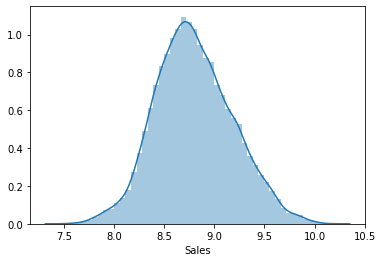

In [8]:
sns.distplot(y_train_log)

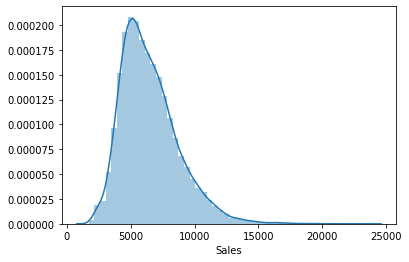

In [9]:
sns.distplot(y_val)

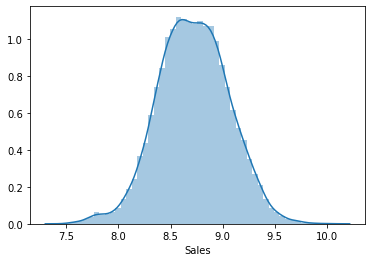

In [10]:
sns.distplot(y_val_log)

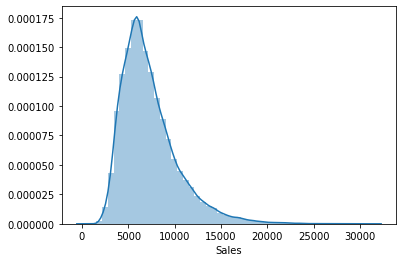

In [11]:
sns.distplot(y_test)

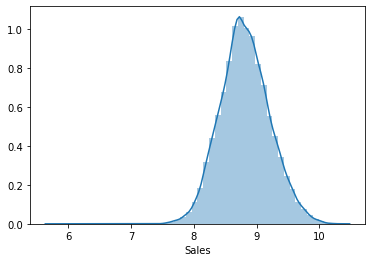

In [12]:
sns.distplot(y_test_log)

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all dates for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all dates for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all dates for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [13]:
from scipy.stats import randint, uniform;
from sklearn.pipeline import make_pipeline;
from sklearn.model_selection import RandomizedSearchCV;
from xgboost import XGBRegressor;
import category_encoders as ce;

groups = train['Store'];

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(random_state=42)
);

param_distributions = {
    'xgbregressor__n_estimators': randint(200, 800),
    'xgbregressor__max_depth': randint(3, 15)
};

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
);

search.fit(x_train, y_train_log, groups=groups);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   59.5s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  1.6min remaining:   48.6s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  2.1min remaining:   31.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.9min finished


In [14]:
print('Best Hyperparameters:', search.best_params_);
print('Cross Validation rmsle:', np.sqrt(-search.best_score_));

Best Hyperparameters: {'xgbregressor__max_depth': 8, 'xgbregressor__n_estimators': 248}
Cross Validation rmsle: 0.06195554663262639


In [15]:
encoder = ce.OrdinalEncoder();
x_train_encoded = encoder.fit_transform(x_train);
x_val_encoded = encoder.transform(x_val);

eval_set = [(x_train_encoded, y_train_log),
           (x_val_encoded, y_val_log)];

model = XGBRegressor(n_estimators=2000, random_state=42);
model.fit(x_train_encoded, y_train_log, eval_set=eval_set, eval_metric='rmse', early_stopping_rounds=50)

[0]	validation_0-rmse:7.47822	validation_1-rmse:7.39615
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:6.73096	validation_1-rmse:6.64893
[2]	validation_0-rmse:6.05845	validation_1-rmse:5.97671
[3]	validation_0-rmse:5.45322	validation_1-rmse:5.37318
[4]	validation_0-rmse:4.90855	validation_1-rmse:4.82889
[5]	validation_0-rmse:4.41838	validation_1-rmse:4.33962
[6]	validation_0-rmse:3.97727	validation_1-rmse:3.89978
[7]	validation_0-rmse:3.58032	validation_1-rmse:3.50451
[8]	validation_0-rmse:3.22311	validation_1-rmse:3.14794
[9]	validation_0-rmse:2.90166	validation_1-rmse:2.82726
[10]	validation_0-rmse:2.61245	validation_1-rmse:2.53959
[11]	validation_0-rmse:2.3522	validation_1-rmse:2.2799
[12]	validation_0-rmse:2.11806	validation_1-rmse:2.04739
[13]	validation_0-rmse:1.90742	validation_1-rmse:1.83761
[14]	validation_0-rmse:1.71795	validation_1-rmse:1.6486

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

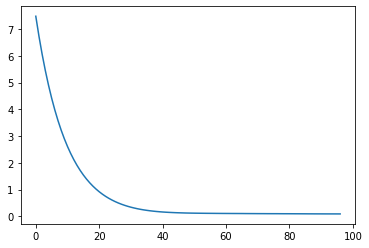

In [16]:
import matplotlib.pyplot as plt;

results = model.evals_result();
train_rmse = results['validation_0']['rmse']
epoch = range(len(train_rmse));
plt.plot(epoch, train_rmse)
plt.show()

## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

In [17]:
import eli5;
from eli5.sklearn import PermutationImportance;
from sklearn.metrics import mean_absolute_error;

/Users/ashwin/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [18]:
def custom_scoror(estimator, x, y_true):
    y_pred = estimator.predict(x);
    return -np.sqrt(mean_absolute_error(y_true, y_pred));

model.evals_result()
permuter = PermutationImportance(
    model,
    scoring=custom_scoror,
    cv='prefit',
    n_iter=5,
    random_state=42
)
permuter.fit(x_val_encoded, y_val_log);
feature_names = x_val_encoded.columns.tolist();
eli5.show_weights(permuter, top=None, feature_names=feature_names)

Weight,Feature
0.2520 ± 0.0032,Customers
0.0304 ± 0.0009,Promo
0.0114 ± 0.0005,CompetitionDistance
0.0068 ± 0.0002,StoreType
0.0048 ± 0.0003,Assortment
0.0022 ± 0.0002,DayOfWeek
0.0022 ± 0.0003,Month
0.0018 ± 0.0002,MonthsPassedSinceOpen
0.0003 ± 0.0001,CompetitionOpenSinceMonth
0.0002 ± 0.0001,Year


In [19]:
print(permuter.feature_importances_)

[ 2.24870540e-03  2.52005247e-01  3.04303636e-02  2.01412400e-05
  6.81114845e-03  4.75258752e-03  1.13980089e-02  2.54286440e-04
 -7.38885660e-04  0.00000000e+00 -1.44294757e-03 -1.83811218e-03
  0.00000000e+00  2.33512686e-04  2.21926180e-03  1.75115336e-03
  0.00000000e+00]


17


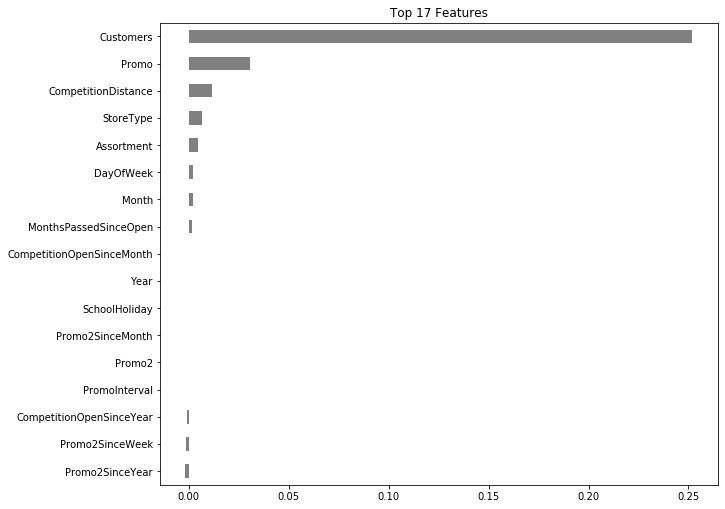

In [20]:
%matplotlib inline

importances = pd.Series(permuter.feature_importances_, x_train_encoded.columns);
importances = importances.sort_values();
n = len(x_train_encoded.columns);
print(n)
plt.figure(figsize=(10, n/2));
plt.title(f'Top {n} Features');
importances[-n:].plot.barh(color='grey');